In [2]:
# Instalación de librería Lime
!pip install lime

##Librerias

In [37]:
# Librerias utilizadas

import itertools
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.decomposition import PCA
from sklearn.preprocessing import minmax_scale
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.preprocessing import MinMaxScaler
from sklearn import preprocessing

from tensorflow import keras
from keras.models import Sequential, Model
from keras.layers import Dense, Embedding, Input, Dropout
from sklearn.neural_network import MLPClassifier


from lime import lime_tabular

from joblib import dump, load

In [38]:
def plot_history(history):

    # Hacemos una grilla de 2 figuras
    fig, axs = plt.subplots(2, figsize = (10, 10))

    # Graficamos los accuracy de ambas bases
    axs[0].plot(history.history["accuracy"], label = "Accuracy entrenamiento")
    axs[0].plot(history.history["val_accuracy"], label = "Accuracy validación")
    axs[0].set_ylabel("Accuracy")
    axs[0].legend(loc = "lower right")
    axs[0].set_title("Accuracy por épocas")

    # Graficamos los errores de ambas bases
    axs[1].plot(history.history["loss"], label="Error entrenamiento")
    axs[1].plot(history.history["val_loss"], label="Error validación")
    axs[1].set_ylabel("Error")
    axs[1].set_xlabel("Época")
    axs[1].legend(loc = "upper right")
    axs[1].set_title("Error por épocas")

    # Mostramos la figura
    plt.show()

In [39]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')


    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


## Cargamos los datos

In [53]:
 # Cargamos la base de datos
 data = pd.read_csv("df.csv")

In [54]:
# Vectorizamos los datos y lo
x = data.drop(['satisfaction'], axis=1)
vectorizer = DictVectorizer(sparse=False)
X = vectorizer.fit_transform(x.to_dict("records"))
X.shape


(124855, 23)

In [55]:
# Ground truth
y = data["satisfaction"].values
classes = np.unique(y)
y.shape

(124855,)

## Separamos los datos

In [56]:
# Separamos en set de entrenamiento, test y validación
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=109)
X_train, X_val , y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=109)

In [57]:
X_train.shape, X_test.shape, X_val.shape

((79907, 23), (24971, 23), (19977, 23))

In [15]:
# Guardamos los sets de datos en archivos
np.save("X_train.npy", X_train)
np.save("X_test.npy", X_test)

np.save("y_train.npy", y_train)
np.save("y_test.npy", y_test)

np.save("X_val.npy", X_val)
np.save("y_val.npy", y_val)

np.save("y.npy", y)


## Primer modelo: Red Neuronal de 7 capas

In [40]:
model_1 = Sequential()

# Input layer
model_1.add(Input(shape=(23,)))

# Hidden layers
model_1.add(Dense(36, activation="relu"))

model_1.add(Dense(256, activation="relu"))

model_1.add(Dense(512, activation="relu"))

model_1.add(Dense(64, activation="relu"))

model_1.add(Dense(32, activation="relu"))

model_1.add(Dense(2, activation="softmax"))

model_1.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 36)                864       
                                                                 
 dense_1 (Dense)             (None, 256)               9472      
                                                                 
 dense_2 (Dense)             (None, 512)               131584    
                                                                 
 dense_3 (Dense)             (None, 64)                32832     
                                                                 
 dense_4 (Dense)             (None, 32)                2080      
                                                                 
 dense_5 (Dense)             (None, 2)                 66        
                                                                 
Total params: 176,898
Trainable params: 176,898
Non-trai

In [41]:
model_1.compile(optimizer="adadelta", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

In [42]:
callback_1 = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10)

In [43]:
history_1 = model_1.fit(X_train, y_train, batch_size=20, epochs=50, callbacks=[callback_1], validation_data=(X_val, y_val))

Epoch 1/50
3996/3996 [==============================] - 24s 4ms/step - loss: 0.6600 - accuracy: 0.7338 - val_loss: 0.6187 - val_accuracy: 0.7905
Epoch 2/50
3996/3996 [==============================] - 18s 5ms/step - loss: 0.5761 - accuracy: 0.7950 - val_loss: 0.5323 - val_accuracy: 0.8055
Epoch 3/50
3996/3996 [==============================] - 17s 4ms/step - loss: 0.5005 - accuracy: 0.8071 - val_loss: 0.4673 - val_accuracy: 0.8152
Epoch 4/50
3996/3996 [==============================] - 18s 5ms/step - loss: 0.4515 - accuracy: 0.8166 - val_loss: 0.4295 - val_accuracy: 0.8262
Epoch 5/50
3996/3996 [==============================] - 18s 4ms/step - loss: 0.4229 - accuracy: 0.8268 - val_loss: 0.4061 - val_accuracy: 0.8383
Epoch 6/50
3996/3996 [==============================] - 18s 4ms/step - loss: 0.4041 - accuracy: 0.8360 - val_loss: 0.3899 - val_accuracy: 0.8460
Epoch 7/50
3996/3996 [==============================] - 18s 4ms/step - loss: 0.3906 - accuracy: 0.8429 - val_loss: 0.3781 - val_ac

In [44]:
y1_preds = model_1.predict(X_test).argmax(axis=-1)


print("Test Accuracy : {}".format(accuracy_score(y_test, y1_preds)))
print("\nClassification Report : ")
print(classification_report(y_test, y1_preds))

781/781 [==============================] - 1s 2ms/step
Test Accuracy : 0.8964398702494895

Classification Report : 
              precision    recall  f1-score   support

         0.0       0.89      0.93      0.91     14101
         1.0       0.91      0.85      0.88     10870

    accuracy                           0.90     24971
   macro avg       0.90      0.89      0.89     24971
weighted avg       0.90      0.90      0.90     24971



In [45]:
dump(model_1, "trained_model_1.joblib")

['trained_model_1.joblib']

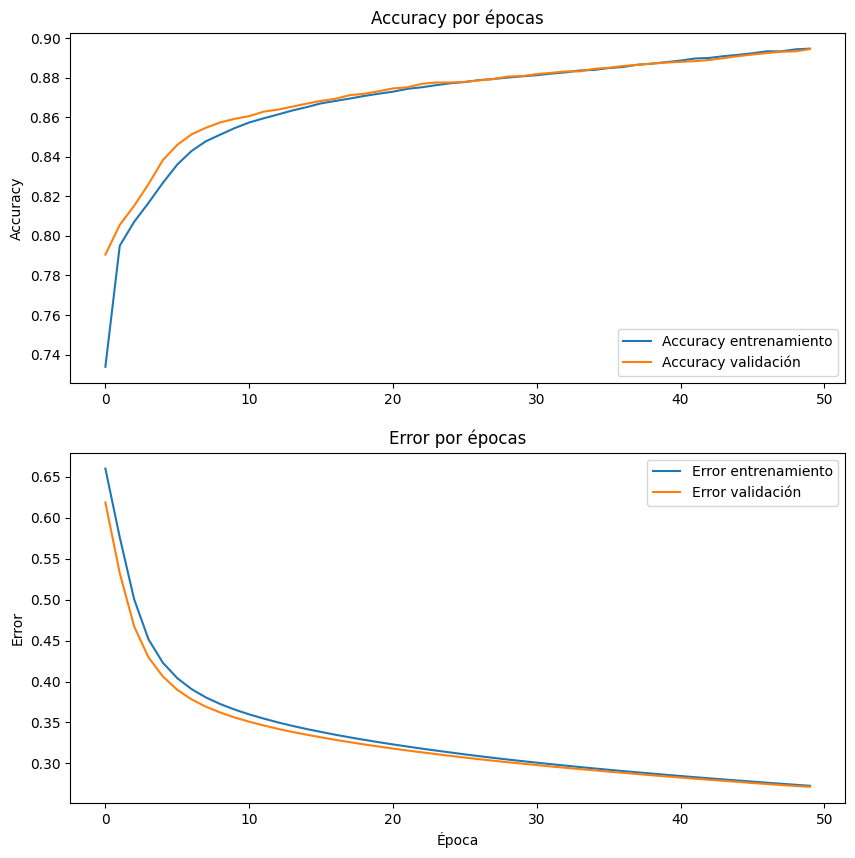

In [46]:
plot_history(history_1)

Normalized confusion matrix


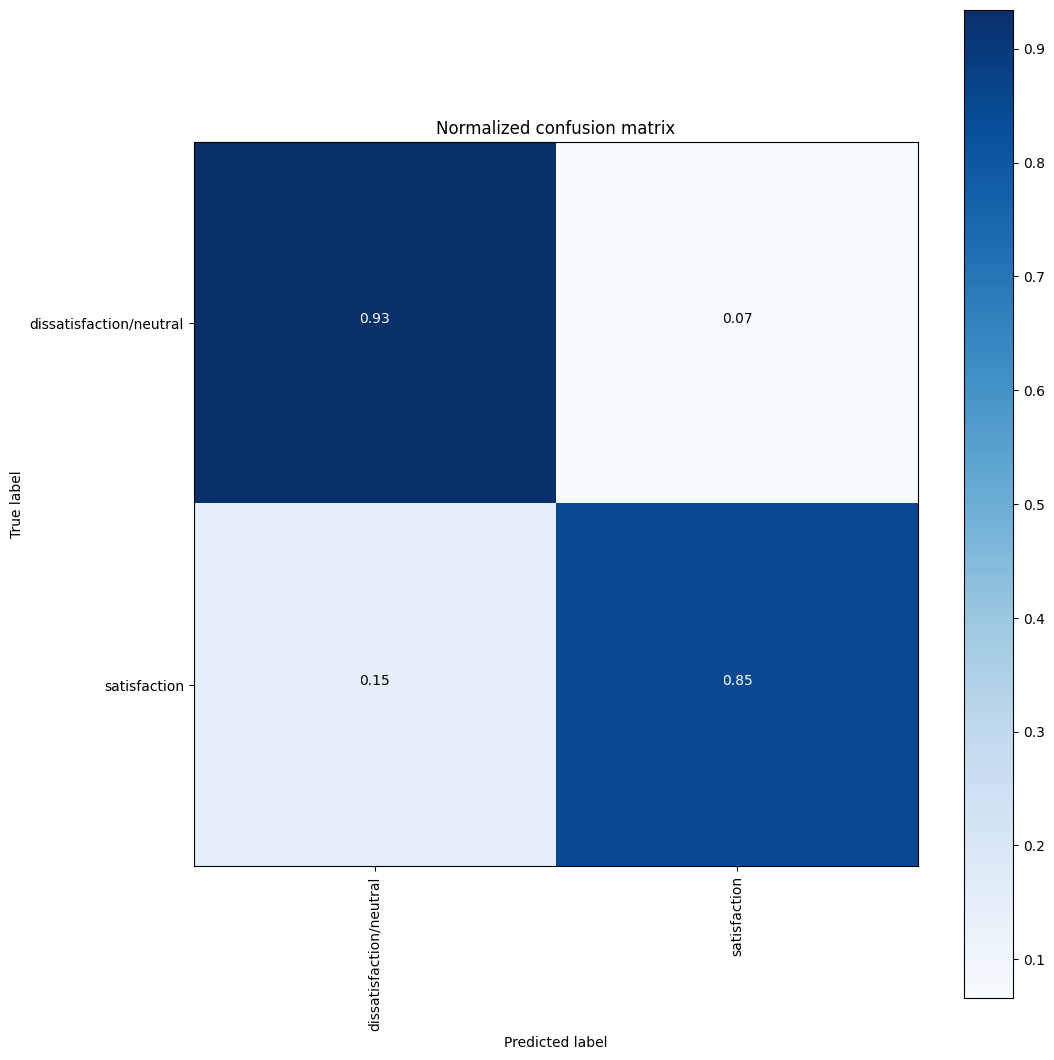

In [47]:
cnf_matrix = confusion_matrix(y_test, y1_preds)
np.set_printoptions(precision=2)
plt.figure(figsize=(11, 11))
plot_confusion_matrix(cnf_matrix, classes=["dissatisfaction/neutral", "satisfaction"], normalize=True, title='Normalized confusion matrix')

plt.show()

## Modelo 2: Red Neuronal con 7 capas + Dropout

In [58]:
model_2 = Sequential()
# Input layer
model_2.add(Dense(23, input_shape=(23,), activation="relu"))

#Hidden layers
model_2.add(Dense(500, activation="relu"))
model_2.add(Dropout(0.1))

model_2.add(Dense(500, activation="relu"))
model_2.add(Dropout(0.1))

model_2.add(Dense(500, activation="relu"))
model_2.add(Dropout(0.1))

model_2.add(Dense(500, activation="relu"))
model_2.add(Dropout(0.1))

model_2.add(Dense(300, activation="relu"))
model_2.add(Dropout(0.1))

# Output layer
model_2.add(Dense(2, activation="softmax"))
model_2.add(Dropout(0.1))

model_2.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_13 (Dense)            (None, 23)                552       
                                                                 
 dense_14 (Dense)            (None, 500)               12000     
                                                                 
 dropout_6 (Dropout)         (None, 500)               0         
                                                                 
 dense_15 (Dense)            (None, 500)               250500    
                                                                 
 dropout_7 (Dropout)         (None, 500)               0         
                                                                 
 dense_16 (Dense)            (None, 500)               250500    
                                                                 
 dropout_8 (Dropout)         (None, 500)              

In [59]:
model_2.compile(optimizer="adadelta", loss="sparse_categorical_crossentropy", metrics=["accuracy"]) # se cambio de adam a adadelta y mejoro a 61. si se parte como adadelta  no da buenos resultados, pero si se parte con adam y luego pasamos a adadleta mejore

In [60]:
callback_2 = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10) # se cambio monitor de los a val accuracy, a medida va mejorando accuracy ir disminiuyendo patience

In [61]:
history_2 = model_2.fit(X_train, y_train, batch_size=20, epochs=50, callbacks=[callback_2], validation_data=(X_val, y_val))  #se intento con batch size de 30 y con epochs de 20

Epoch 1/50
3996/3996 [==============================] - 24s 5ms/step - loss: 1.9090 - accuracy: 0.6540 - val_loss: 0.6148 - val_accuracy: 0.7524
Epoch 2/50
3996/3996 [==============================] - 21s 5ms/step - loss: 1.8375 - accuracy: 0.7183 - val_loss: 0.4978 - val_accuracy: 0.7707
Epoch 3/50
3996/3996 [==============================] - 20s 5ms/step - loss: 1.7465 - accuracy: 0.7254 - val_loss: 0.4478 - val_accuracy: 0.7825
Epoch 4/50
3996/3996 [==============================] - 21s 5ms/step - loss: 1.6747 - accuracy: 0.7342 - val_loss: 0.4386 - val_accuracy: 0.7945
Epoch 5/50
3996/3996 [==============================] - 21s 5ms/step - loss: 1.6310 - accuracy: 0.7439 - val_loss: 0.4266 - val_accuracy: 0.8114
Epoch 6/50
3996/3996 [==============================] - 21s 5ms/step - loss: 1.6108 - accuracy: 0.7541 - val_loss: 0.4296 - val_accuracy: 0.8228
Epoch 7/50
3996/3996 [==============================] - 23s 6ms/step - loss: 1.5782 - accuracy: 0.7634 - val_loss: 0.4319 - val_ac

In [62]:
y2_preds = model_2.predict(X_test).argmax(axis=-1)

print("Test Accuracy : {}".format(accuracy_score(y_test, y2_preds)))
print("\nClassification Report : ")
print(classification_report(y_test, y2_preds))

781/781 [==============================] - 1s 2ms/step
Test Accuracy : 0.9016459092547355

Classification Report : 
              precision    recall  f1-score   support

         0.0       0.89      0.94      0.91     14101
         1.0       0.91      0.86      0.88     10870

    accuracy                           0.90     24971
   macro avg       0.90      0.90      0.90     24971
weighted avg       0.90      0.90      0.90     24971



In [63]:
# Guardamos el modelo
dump(model_2, "trained_model_2.joblib")

['trained_model_2.joblib']

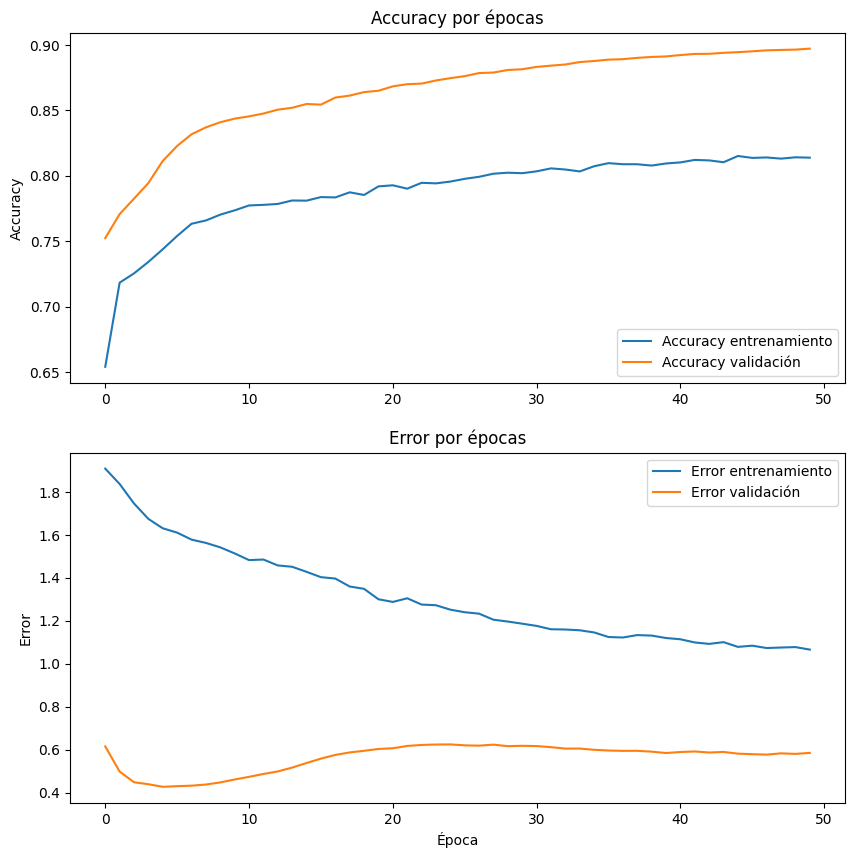

In [64]:
 )

Normalized confusion matrix


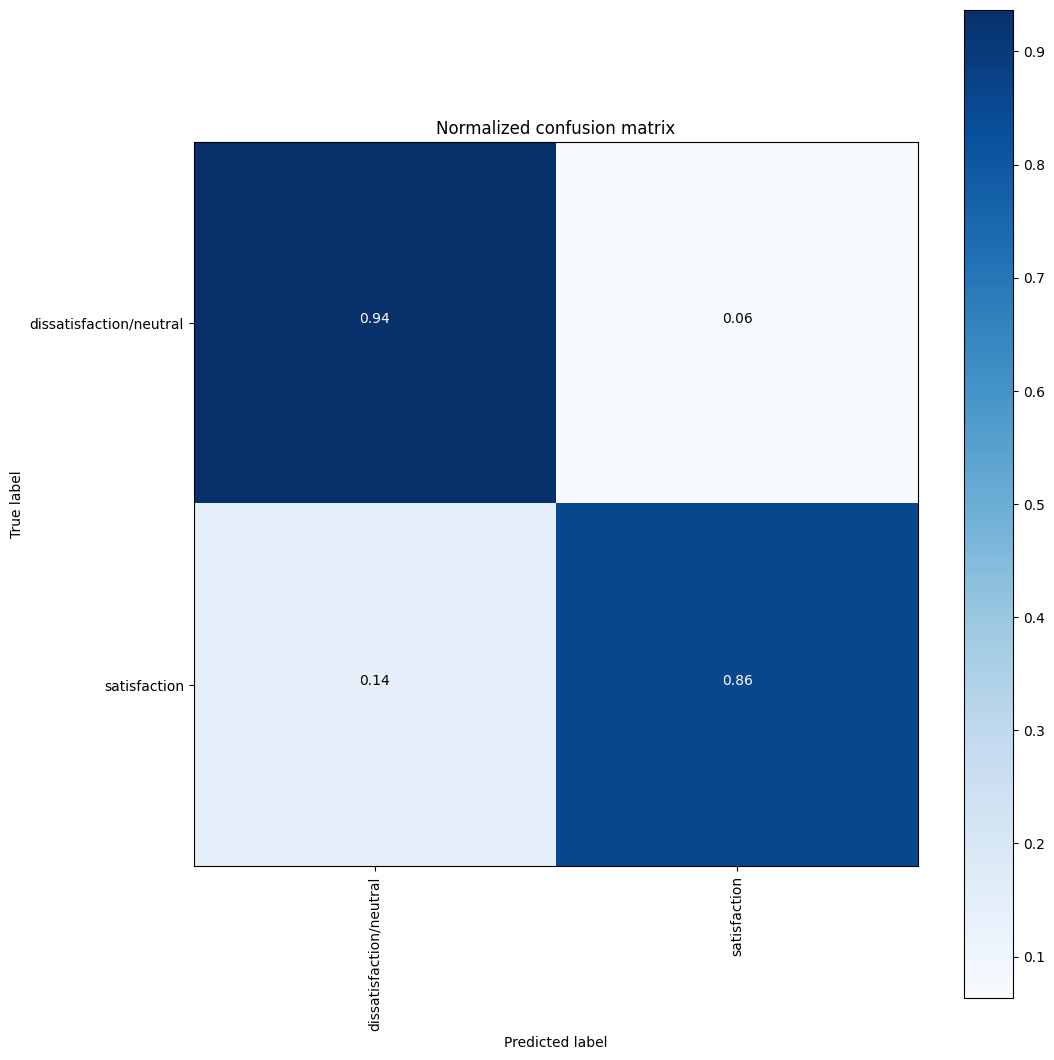

In [66]:
cnf_matrix = confusion_matrix(y_test, y2_preds)
np.set_printoptions(precision=2)
plt.figure(figsize=(11, 11))
plot_confusion_matrix(cnf_matrix, classes=["dissatisfaction/neutral", "satisfaction"], normalize=True, title='Normalized confusion matrix')

plt.show()

## Modelo 3: MLP de sklearn

In [17]:
model_3 = MLPClassifier()

model_3.fit(X_train, y_train)

MLPClassifier()

In [18]:
layer_sizes = [X.shape[1]] + [coef.shape[1] for coef in model_3.coefs_]

print("Number of Layers:", model_3.n_layers_)
print("Number of nodes per layer:")
for layer, size in enumerate(layer_sizes):
    print(f"Layer {layer}: {size} nodes")

print("Number of Output Units:", model_3.n_outputs_)
print("Hidden Layer Sizes:", model_3.hidden_layer_sizes)
print("Activation Function:", model_3.activation)
print("Solver:", model_3.solver)
print("Alpha (Regularization Parameter):", model_3.alpha)
print("Learning Rate Schedule:", model_3.learning_rate)
print("Maximum Number of Iterations:",model_3.max_iter)
print("Batch Size:", model_3.batch_size)

Number of Layers: 3
Number of nodes per layer:
Layer 0: 23 nodes
Layer 1: 100 nodes
Layer 2: 1 nodes
Number of Output Units: 1
Hidden Layer Sizes: (100,)
Activation Function: relu
Solver: adam
Alpha (Regularization Parameter): 0.0001
Learning Rate Schedule: constant
Maximum Number of Iterations: 200
Batch Size: auto


In [19]:
y3_preds = model_3.predict(X_test)

print("Test Accuracy : {}".format(accuracy_score(y_test, y3_preds)))
print("\nClassification Report : ")
print(classification_report(y_test, y3_preds))

Test Accuracy : 0.956669736894798

Classification Report : 
              precision    recall  f1-score   support

         0.0       0.95      0.97      0.96     14101
         1.0       0.96      0.94      0.95     10870

    accuracy                           0.96     24971
   macro avg       0.96      0.95      0.96     24971
weighted avg       0.96      0.96      0.96     24971



In [20]:
dump(model_3, "trained_model_3.joblib")

['trained_model_3.joblib']

Normalized confusion matrix


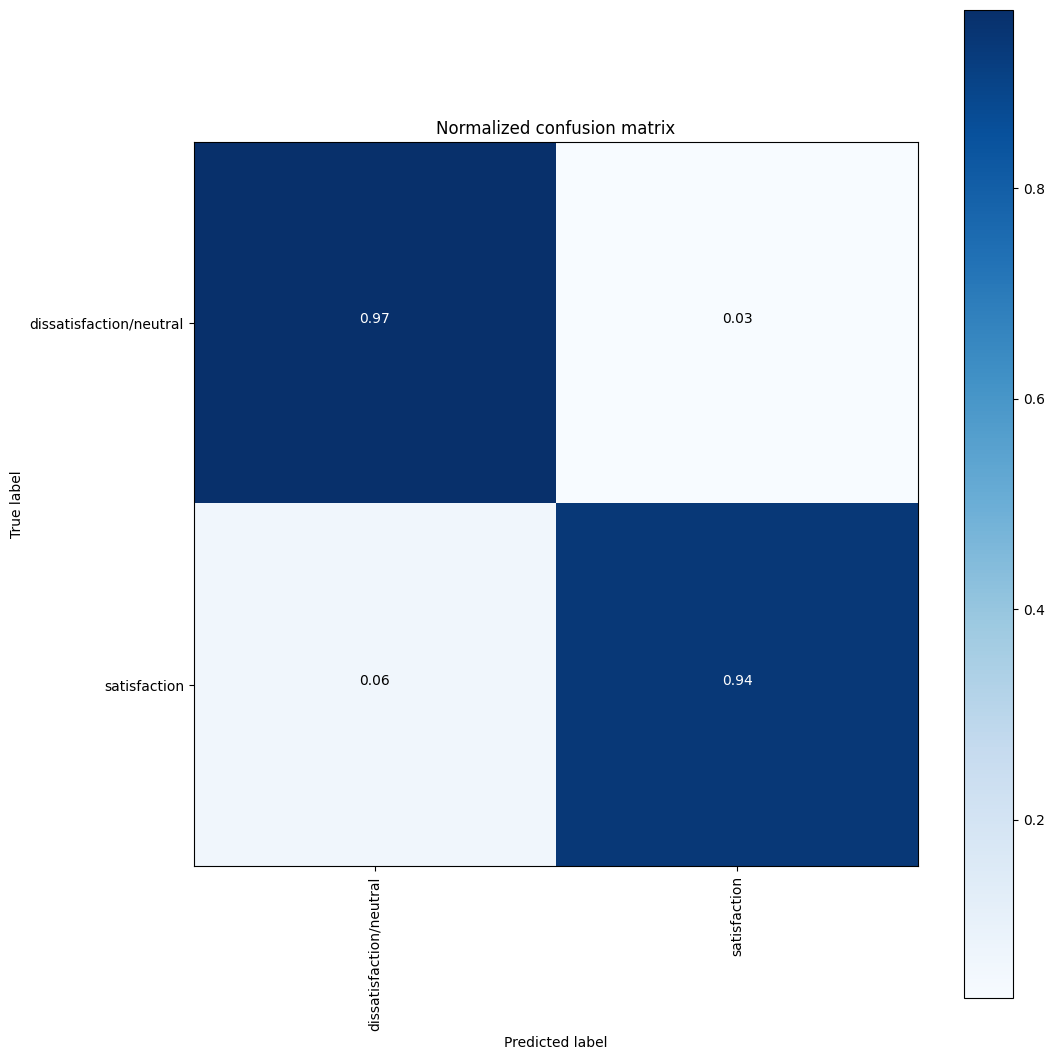

In [22]:
cnf_matrix = confusion_matrix(y_test, y3_preds)
np.set_printoptions(precision=2)
plt.figure(figsize=(11, 11))
plot_confusion_matrix(cnf_matrix, classes=["dissatisfaction/neutral", "satisfaction"], normalize=True, title='Normalized confusion matrix')

plt.show()

In [36]:
explainer = lime_tabular.LimeTabularExplainer(X_train, mode="classification", class_names= ["dissatisfaction/neutral", "satisfaction"], feature_names=x.columns)

exp = explainer.explain_instance(X_val[19976], model_3.predict_proba)
exp.show_in_notebook(show_table=True)

## Live Demo

In [ ]:
# Cargamos la data
X_train, X_test, y_train, y_test = np.load("X_train.npy"), np.load("X_test.npy"), np.load("y_train.npy"), np.load("y_test.npy")
X_val, y_val = np.load("X_val.npy"), np.load("y_val.npy")

In [ ]:
# Cargamos los modelos
model_1 = load("trained_model_1.joblib")
model_2 = load("trained_model_2.joblib")
model_3 = load("trained_model_3.joblib")

In [ ]:
y1_preds = model_1.predict(X_test)

print("Test Accuracy : {}".format(accuracy_score(y_test, y1_preds)))
print("\nClassification Report : ")
print(classification_report(y_test, y1_preds))

In [ ]:
y2_preds = model_2.predict(X_test)

print("Test Accuracy : {}".format(accuracy_score(y_test, y3_preds)))
print("\nClassification Report : ")
print(classification_report(y_test, y2_preds))

In [ ]:
y3_preds = model_3.predict(X_test)

print("Test Accuracy : {}".format(accuracy_score(y_test, y3_preds)))
print("\nClassification Report : ")
print(classification_report(y_test, y3_preds))